# **Photovoltaic panel segmentation on building facades**

Ayca Duran*, Pedram Mirabian, Panagiotis Karapiperis, Christoph Waibel,
Bernd Bickel and Arno Schlueter

## Step 9: Test Set Evaluation (Paper Results)

This notebook reproduces the results presented in the paper, specifically in Figure 3 and Figure 9.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import ast
from collections import defaultdict

# Find a Times New Roman font path
times_path = [f.fname for f in fm.fontManager.ttflist if 'Times New Roman' in f.name][0]
times_font = fm.FontProperties(fname=times_path)
times_prop = fm.FontProperties(fname=times_path, size=18)

# Apply globally
plt.rcParams['font.family'] = times_font.get_name()
sns.set_style("whitegrid")


In [4]:
'''
GLOBAL SETUP
'''
from pathlib import Path
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount= False)
    repo_path = Path("/content/drive/MyDrive/PVFINDER")
except:
    repo_path = Path.cwd().parent

human_path =        repo_path / "files" / "05_micro_results" / "human" / "human_mean_annotator.csv"
mrcnn_path =        repo_path / "files" / "05_micro_results" / "maskrcnn" / "MRCNN_stratAug_BestIoU_Model45_t85.csv"
segf_path =         repo_path / "files" / "05_micro_results" / "segformer" / "SegFormer_stratAug_noNorm.csv"

pv_database_path =  repo_path / "files" / "00_data_collection" / "00_pv_facades_database.xlsx"

In [ ]:
# --- IoU helper ---
def iou_from_counts(tp, fp, fn):
    den = tp + fp + fn
    if den == 0:
        return 1.0  # empty-empty; consistent with your convention
    return tp / den

# --- Load ---

mrcnn = pd.read_csv(mrcnn_path)
segf  = pd.read_csv(segf_path)
human = pd.read_csv(human_path)

# --- Standardize keys ---
mrcnn["image_key"] = mrcnn["image_id"]
segf["image_key"]  = segf["pr_filename"].str.replace(".png", ".jpg", regex=False)
human["image_key"] = human["image"]

# --- Compute/assign IoUs ---
# Mask R-CNN: recompute from counts (or you can keep img_iou)
for c in ["tp_pixels", "fp_pixels", "fn_pixels"]:
    mrcnn[c] = mrcnn[c].fillna(0)
mrcnn["maskrcnn_iou"] = mrcnn.apply(
    lambda r: iou_from_counts(r["tp_pixels"], r["fp_pixels"], r["fn_pixels"]),
    axis=1
)

# SegFormer: compute from tp_green/fp_orange/fn_red
for c in ["tp_green", "fp_orange", "fn_red"]:
    segf[c] = segf[c].fillna(0)
segf["segformer_iou"] = segf.apply(
    lambda r: iou_from_counts(r["tp_green"], r["fp_orange"], r["fn_red"]),
    axis=1
)

# Human: already provided
human["human_iou"] = human["human_mean_iou"]

# --- Keep only the keys and IoUs ---
mrcnn_keep = mrcnn[["image_key", "maskrcnn_iou"]]
segf_keep  = segf[["image_key", "segformer_iou"]]
human_keep = human[["image_key", "human_iou"]]

# --- Merge into final df ---
df_final = (
    human_keep
    .merge(segf_keep, on="image_key", how="outer")
    .merge(mrcnn_keep, on="image_key", how="outer")
)[["image_key", "human_iou", "segformer_iou", "maskrcnn_iou"]]

df_final["image_key"] = df_final["image_key"].str.split(".", n=1).str[0]

# --- Filter to only images with PVs in ground truth ---
human["image_key"] = human["image_key"].str.split(".", n=1).str[0]
gt_pv_keys = human.loc[
    (human["TP_pixels"] + human["FN_pixels"]) > 0,
    "image_key"
]

df_final_gt_pv = df_final[df_final["image_key"].isin(gt_pv_keys)]
df_final_gt_pv.head()


,image_key,human_iou,segformer_iou,maskrcnn_iou
0,013_gsv_00_jpg,0.747855,0.970659,0.949392
1,014_gsv_00_jpg,0.148773,0.595639,0.668849
2,014_web_00_jpg,0.287230,0.563902,0.661655
3,021_web_00_jpg,0.525544,0.346654,0.124450
4,035_web_00_jpg,0.312136,0.359314,0.278154


In [ ]:
# --- Read categorical data for images ---
df = pd.read_excel(pv_database_path)
df.head()

,project index,project name,affiliation,coordinates,notes,country,address,plant year,project type,project function,...,Context,Facade Ratio,Orientation,Inclination (°),Type of Integration,Design Concept 1,Design Concept 2,Composition,Module Orientation,Ornamentation
0,1,Alan Gilbert Building,Metier3,"-37.800201566465404, 144.95922885727185",gsv_ok,Australia,Melbourne,2001,New,Educational,...,Urban,>0.5,N,80,Warm Facade,Ho,Banner,Dominant,Vertical,No
1,2,K2 Apartments,DesignInc,"-37.85214019705778, 144.98272568102158",gsv_ok,Australia,Melbourne,2007,New,Residential,...,Urban,<0.5,N,50,Rainscreen,He,Depth,Integration,Vertical,No
2,3,Active Energy Tower Fronius,-,"48.165517221482034, 14.029311400019",gsv_ok,Austria,-,2013,New,Office,...,Urban,>0.5,All,90,Warm Facade,Ho,Flat,Integration,Vertical,No
3,4,Genböch Bungalow Best Ager,-,"48.19502514696886, 14.251533727496355",gsv_missing,Austria,-,2011,New,Residential,...,Agglomeration,<0.5,SW,75,Rainscreen,Ho,Flat,Dominant,Vertical,No
4,5,Dwelling Houses Spinnereistrasse,HK Architekten,"47.496664840942536, 9.692686518342924",gsv_ok,Austria,Hard,2003,-,Residential,...,Agglomeration,<0.5,E;S;W,90,Solar Control,He,Rhythmic,Integration,Vertical,No


In [5]:
# --- Map image keys to project indices ---
unique_project_idx = list(dict.fromkeys(
    df_final_gt_pv["image_key"].str.split("_").str[0].astype(int).tolist()
))

image_keys = df_final_gt_pv["image_key"].to_list()

grouped = defaultdict(list)

for key in image_keys:
    # example: '310_web_99_jpg'
    proj_id = int(key[:3])                 # -> 310
    grouped[proj_id].append(key)

# convert to normal dict for easier mapping later
grouped = dict(grouped)

filtered_df = df[df['project index'].isin(unique_project_idx)]
filtered_df = filtered_df.reset_index()
filtered_df["Comparisons"] = filtered_df["project index"].map(grouped)
filtered_df.head()


,index,project index,project name,affiliation,coordinates,notes,country,address,plant year,project type,...,Facade Ratio,Orientation,Inclination (°),Type of Integration,Design Concept 1,Design Concept 2,Composition,Module Orientation,Ornamentation,Comparisons
0,12,13,Power Plant Dorferbach,Ing. Erwin Mair,"47.018176795257794, 12.34330860074538",gsv_ok,Austria,Prägraten,2005,-,...,<0.5,S,90,Rainscreen,He,Flat,Subordination,Vertical,No,[013_gsv_00_jpg]
1,13,14,Power Tower,Weber + Hofer,"48.29327393980596, 14.291550250456305",gsv_ok,Austria,Linz,2008,-,...,>0.5,SW,90,Rainscreen,He,Rhythmic,Integration,Vertical,No,"[014_gsv_00_jpg, 014_web_00_jpg]"
2,20,21,Euro Space Center,Samyn & Partners,"50.0082860403888, 5.219046119665667",gsv_ok,Belgium,Libin-Transinne,2009,Retrofit,...,1,SE;SW,45,Solar Control,He,ZigZag,Dominant,Centric,No,[021_web_00_jpg]
3,34,35,Copenhagen towers hotel,Norman Foster,"55.627060289778385, 12.577268766854822",gsv_ok,Denmark,Copenhagen,2009,-,...,>0.5,E;S;W,90,Rainscreen,Ho,Flat,Integration,Horizontal,No,[035_web_00_jpg]
4,59,60,Elobau Factory 2,HHS Planer + Architekten AG,"47.83902827110656, 10.011680412658434",gsv_ok,Germany,Leutkirch,2012,Retrofit,...,>0.5,S,50,Solar Control,Ho,ZigZag,Dominant,Horizontal,No,[060_gsv_00_jpg]


In [6]:
# --- Merge categorical data with IoU data ---

# Comparisons column is parsed as list
filtered_df["Comparisons"] = filtered_df["Comparisons"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Explode to one row per image filename
exploded_df = filtered_df.explode("Comparisons")
exploded_df["image_key"] = exploded_df["Comparisons"] 

# Merge on image_key
merged_df = pd.merge(df_final_gt_pv, exploded_df, on="image_key", how="left")


In [ ]:
# Example color palette (customize as you like)
palette = {
    "human_iou": "skyblue",      # Blue
    "segformer_iou": "dimgray",  # Orange
    "maskrcnn_iou": "darkgray"    # Green
}


# Choose categorical features to analyze
categorical_cols = [
    'project type',
       'pv system', 'module type', 'cell type', 'transparency', 'Color', 'Texture',
       'Module Size', 'Module Shape', 'Cell Visibility', 'Context',
       'Facade Ratio', 'Orientation', 'Inclination (°)', 'Type of Integration',
       'Design Concept 1', 'Design Concept 2', "Composition"
]

# IoU columns
iou_cols = ["human_iou", "segformer_iou", "maskrcnn_iou"]

counts_dicts = {}

for cat in categorical_cols:
    counts_dicts[cat] = (
        merged_df.groupby(cat)["image_key"]
        .nunique()
        .to_dict()
    )
    
# Melt the dataframe
melted_df = merged_df.melt(
    id_vars=categorical_cols,
    value_vars=iou_cols,
    var_name="IoU_Type",
    value_name="IoU_Value"
)


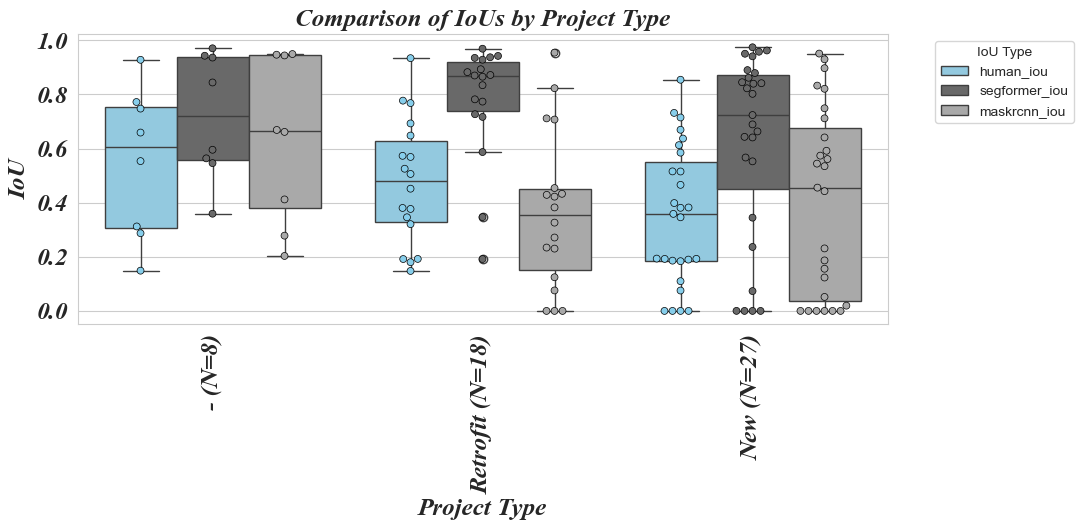

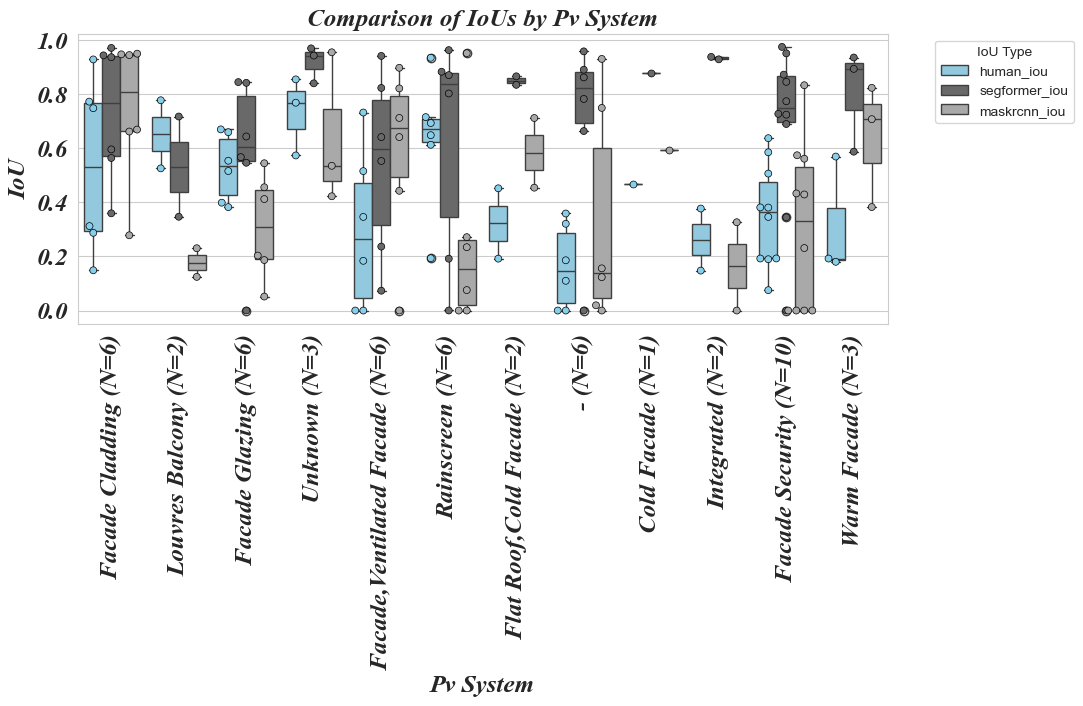

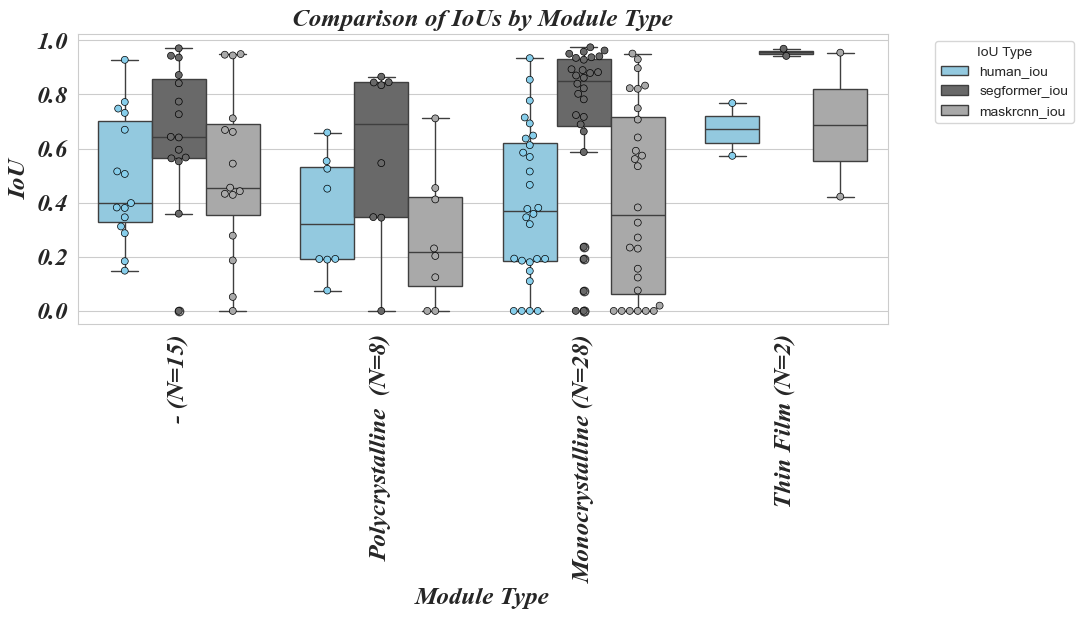

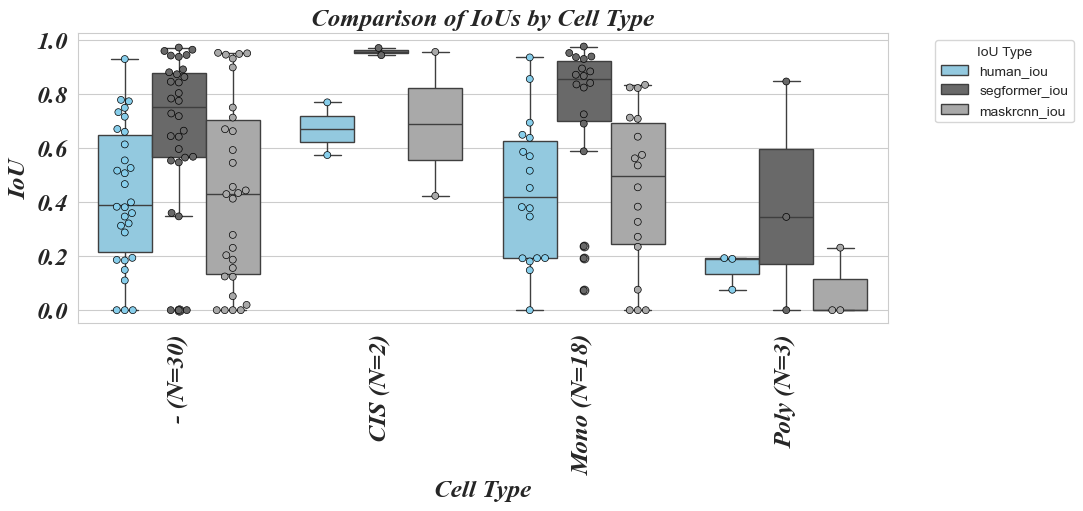

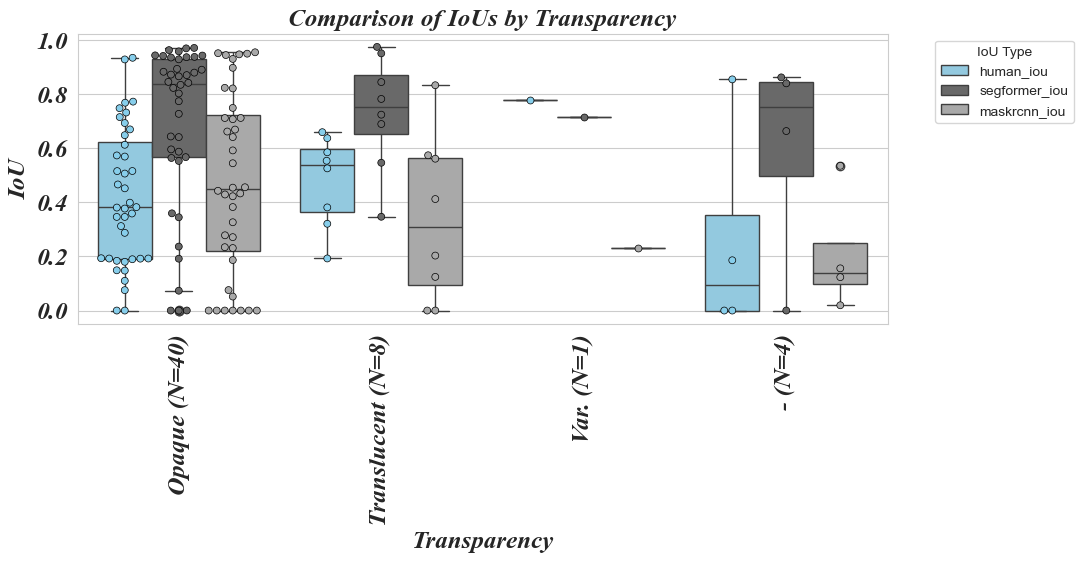

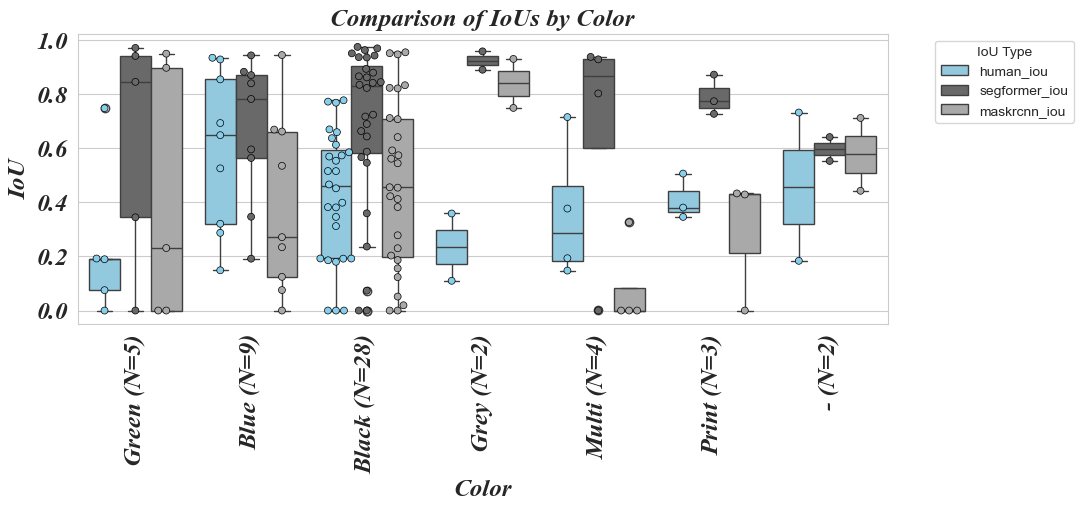

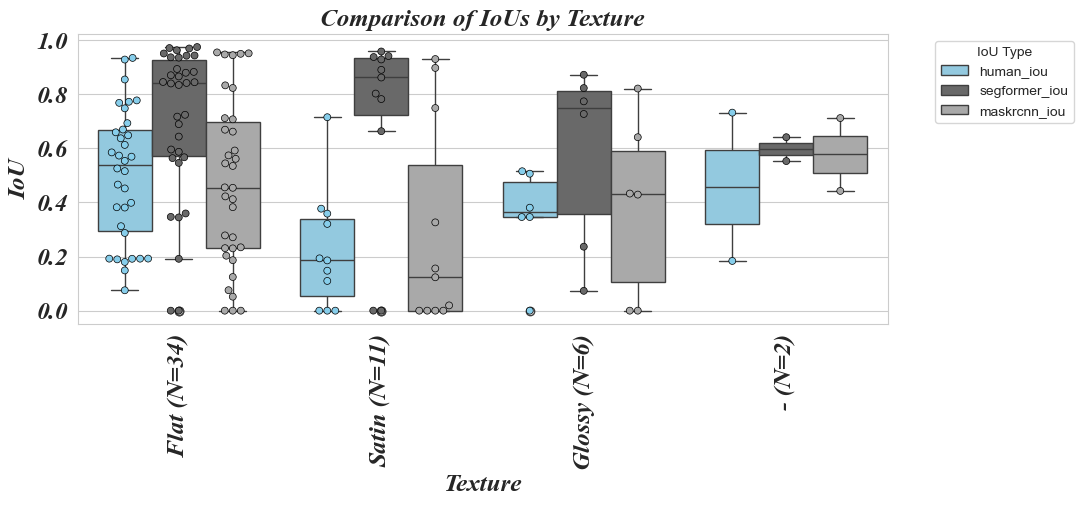

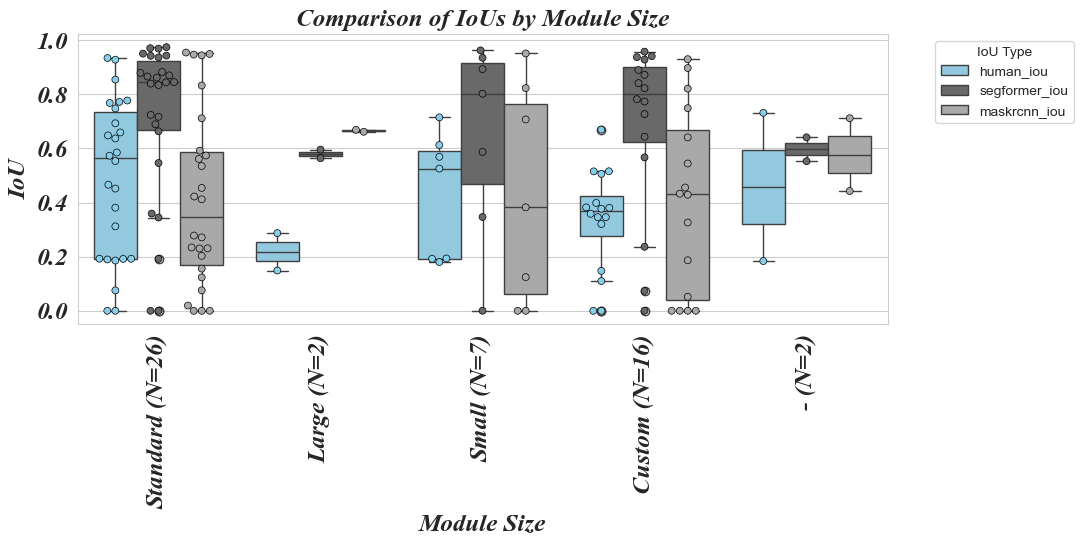

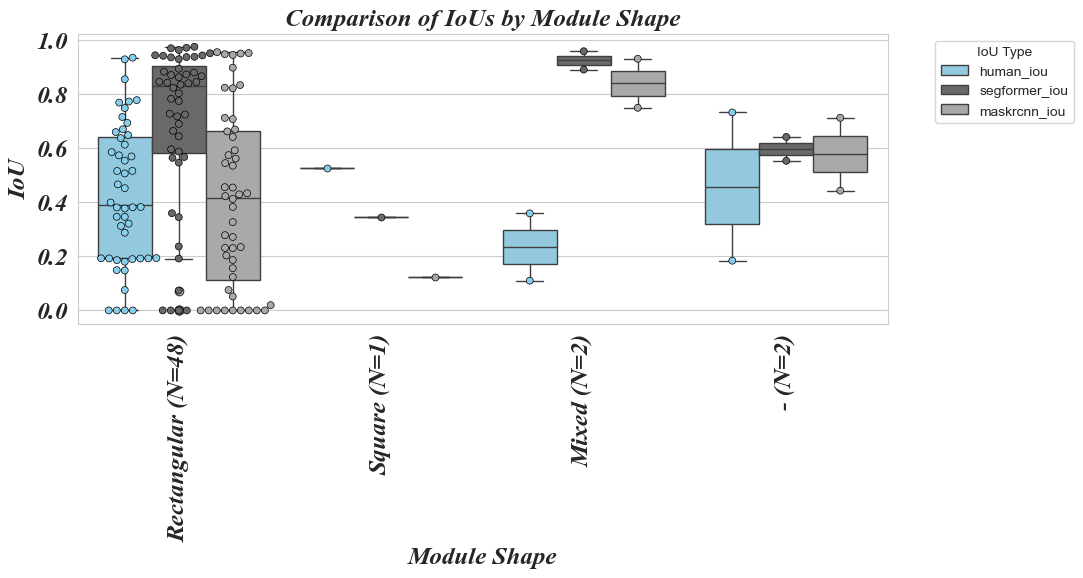

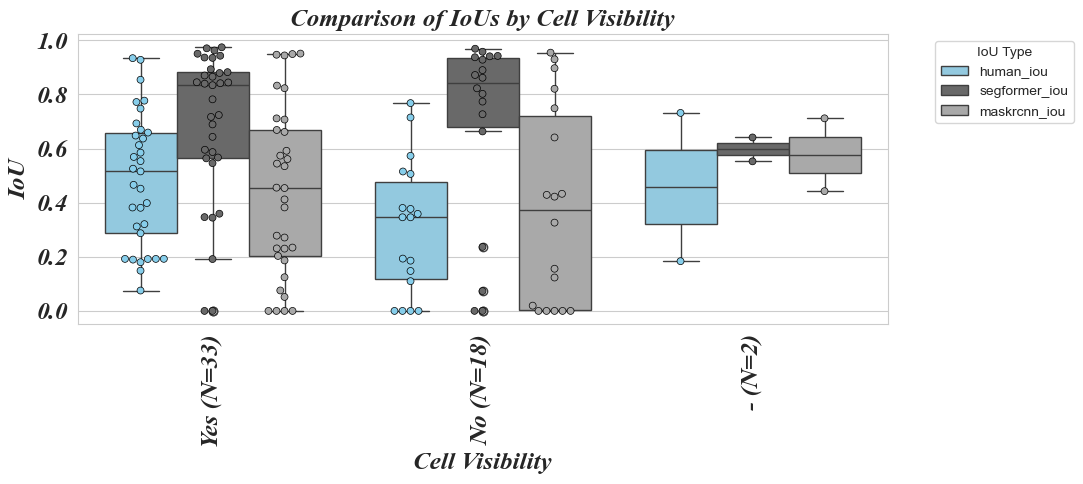

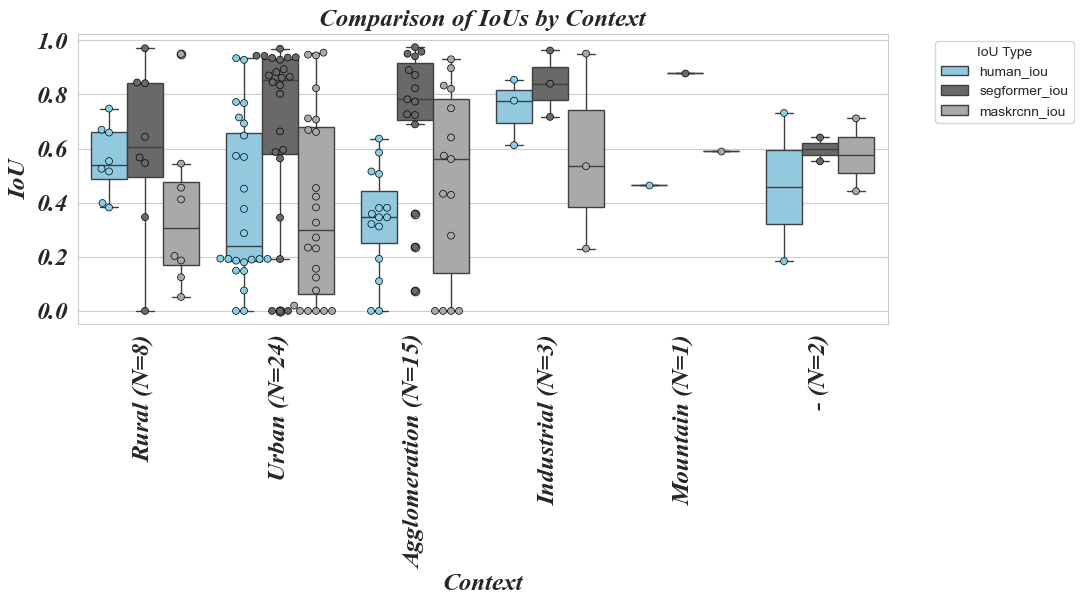

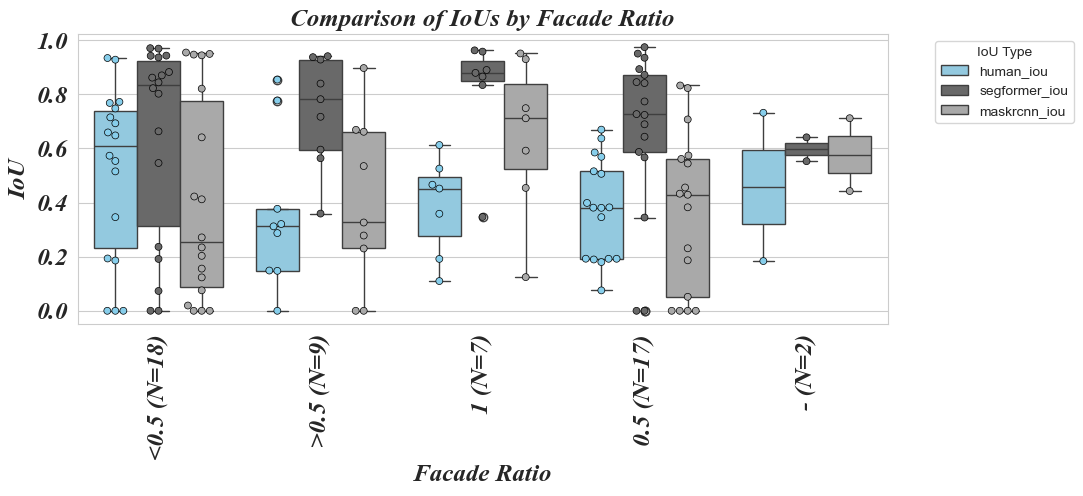

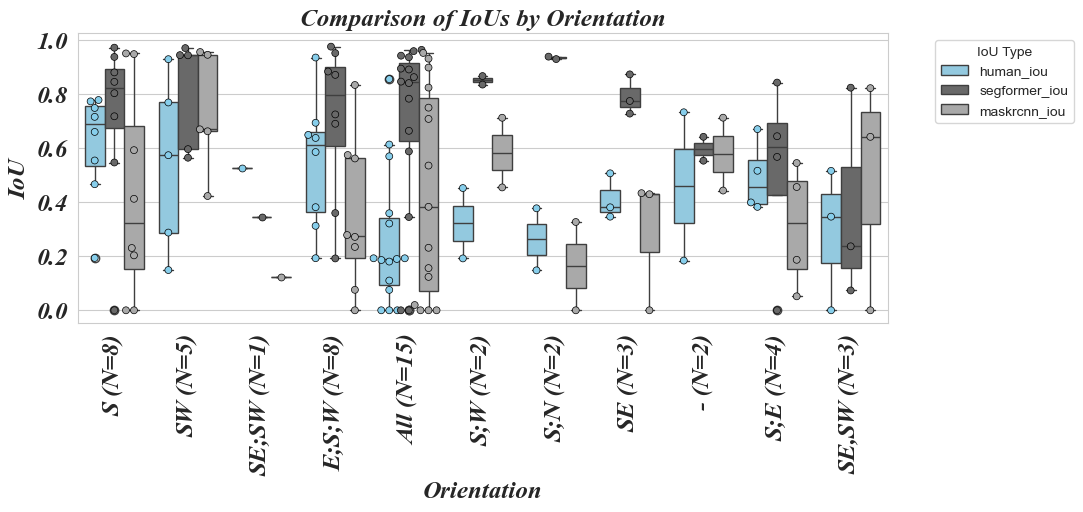

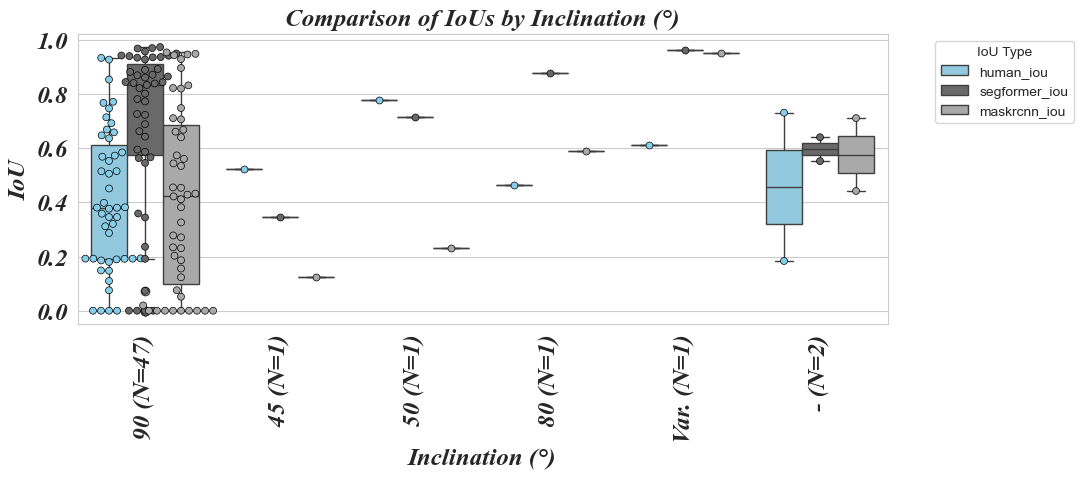

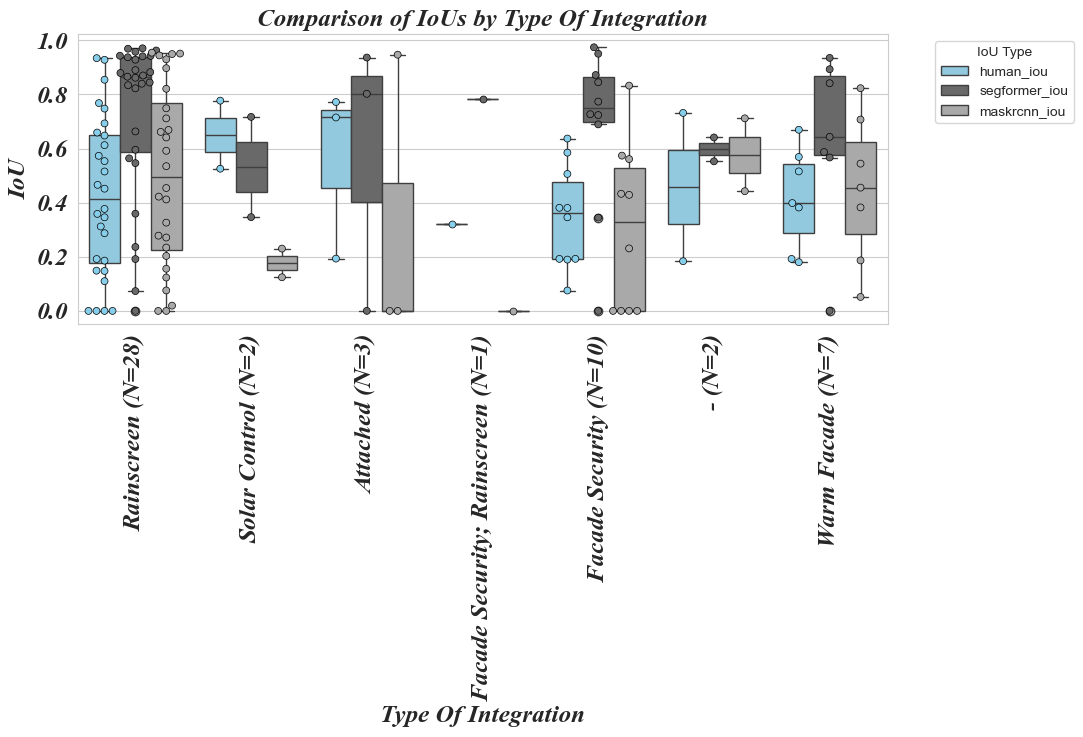

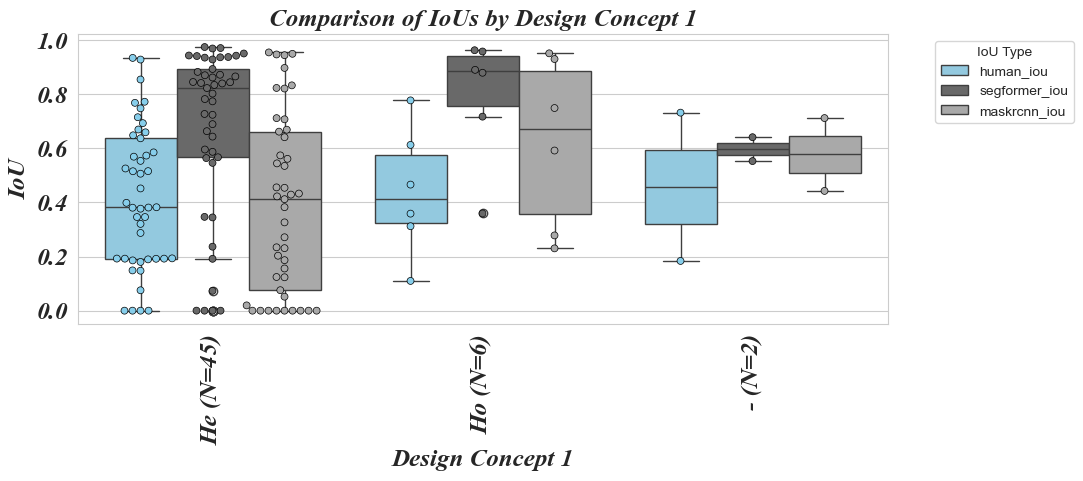

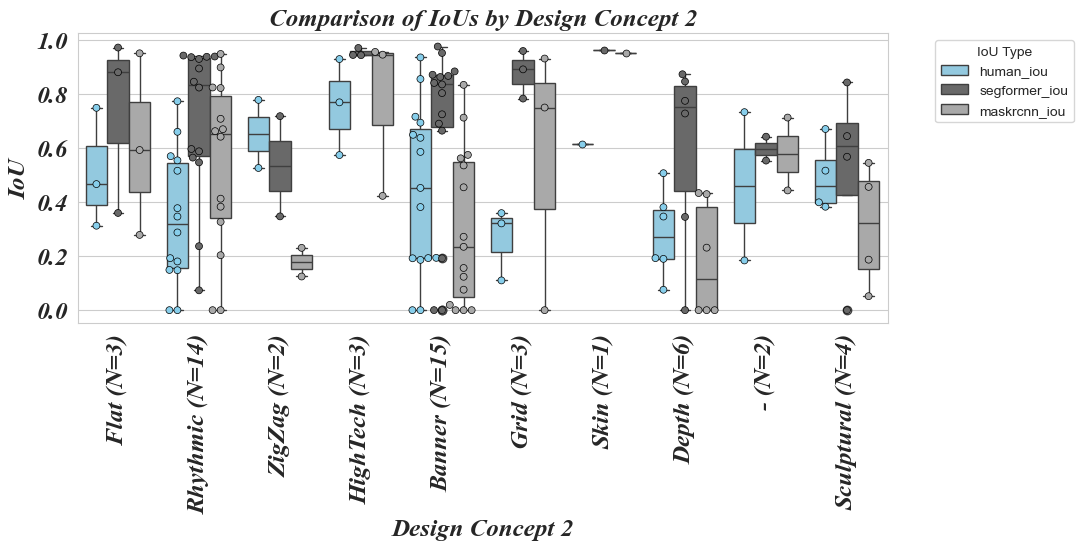

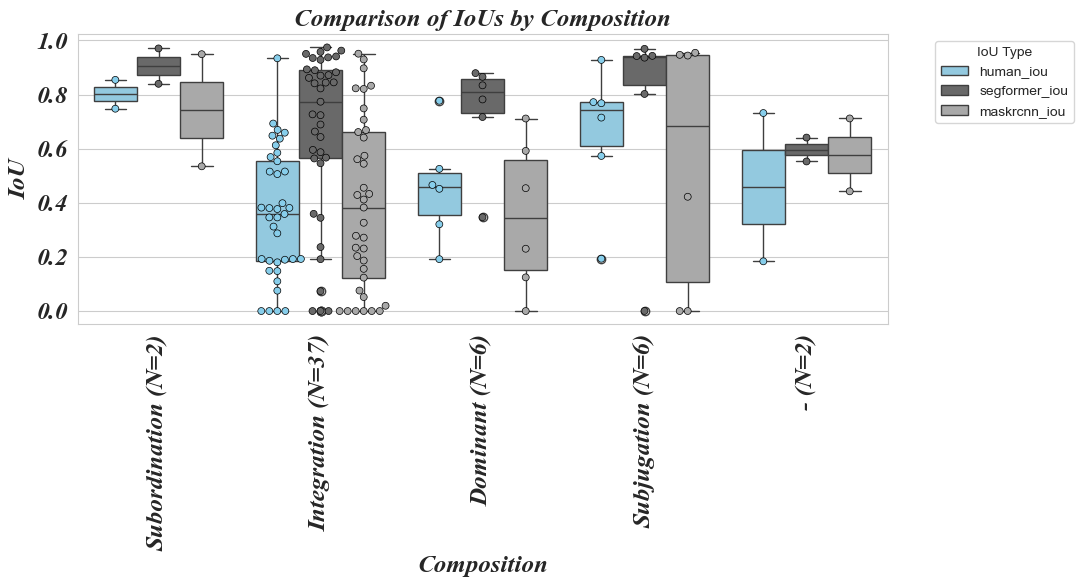

In [8]:
for cat in categorical_cols:
    cat_title = cat.title()  # Capitalize each word

    count_map = counts_dicts[cat]
    valid_categories = {k for k, v in count_map.items() if v > 0}
    filtered_data = melted_df[melted_df[cat].isin(valid_categories)].copy()

    # Create labels with sample sizes
    filtered_data[f"{cat}_label"] = filtered_data[cat].apply(
        lambda x: f"{x} (N={count_map.get(x, 0)})"
    )

    plt.figure(figsize=(12, 5))
    
    # Create boxplot
    ax = sns.boxplot(
        data=filtered_data,
        x=f"{cat}_label",
        y="IoU_Value",
        hue="IoU_Type",
        palette=palette,
        dodge=True
    )

    # Add swarmplot overlay
    sns.swarmplot(
        data=filtered_data,
        x=f"{cat}_label",
        y="IoU_Value",
        hue="IoU_Type",
        palette=palette,
        dodge=True,
        ax=ax,
        edgecolor='k',
        linewidth=0.5,
        size=5
    )

    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    n_hue = filtered_data["IoU_Type"].nunique()
    ax.legend(handles[:n_hue], labels[:n_hue], title="IoU Type", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Styling
    plt.title(f"Comparison of IoUs by {cat_title}", fontproperties=times_prop)
    plt.xlabel(cat_title, fontproperties=times_prop)
    plt.ylabel("IoU", fontproperties=times_prop)
    plt.xticks(rotation=90, fontproperties=times_prop)
    plt.yticks(fontproperties=times_prop)
    plt.subplots_adjust(bottom=0.3, right=0.8)
    
    plt.show()


# CIs

Clustered bootstrap CIs for IoU/F1 by strata (PROJECT-MEAN)
- Estimates are "mean of per-project means" (each project equal weight)
- Paired differences are "mean of per-project mean differences"

In [9]:
import numpy as np
import pandas as pd
from typing import Optional, Union, Dict, Tuple
import re
import matplotlib.pyplot as plt

In [ ]:
# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------

def _percentile_interval(samples, alpha=0.95):
    lo = np.percentile(samples, (1 - alpha) / 2 * 100.0)
    hi = np.percentile(samples, (1 + alpha) / 2 * 100.0)
    return float(lo), float(hi)

def f1_from_iou(iou):
    if pd.isna(iou):
        return np.nan
    return 0.0 if iou <= 0 else 2 * iou / (1 + iou)

# -----------------------------------------------------------------------------
# Cluster bootstrap (PROJECT-MEAN estimand)
# -----------------------------------------------------------------------------

def mean_ci_clustered_project_mean(
    df: pd.DataFrame,
    value_col: str,
    cluster_col: str,
    B: int = 2000,
    alpha: float = 0.95,
    min_clusters: int = 2,
    seed: int = 12345
) -> Tuple[float, float, float]:
    """
    Project-level clustered bootstrap CI for the mean of value_col where the
    estimand is the mean of per-project means (equal project weight).

    Steps:
      1) Compute per-project mean of value_col.
      2) Point estimate = mean of per-project means.
      3) Bootstrap by resampling projects with replacement; each sampled project
         contributes its per-project mean (duplicates allowed).
      4) Percentile CI on bootstrap distribution.
    """
    df = df[[value_col, cluster_col]].dropna()
    if df.empty:
        return np.nan, np.nan, np.nan

    proj_means = df.groupby(cluster_col)[value_col].mean()
    clusters = proj_means.index.to_numpy()
    point = float(proj_means.mean())

    if len(clusters) < min_clusters:
        return point, np.nan, np.nan

    rng = np.random.default_rng(seed)
    boots = np.empty(B, dtype=float)

    for b in range(B):
        sampled = rng.choice(clusters, size=len(clusters), replace=True)
        boots[b] = float(proj_means.loc[sampled].mean())

    lo, hi = _percentile_interval(boots, alpha=alpha)
    return point, lo, hi

def mean_diff_ci_clustered_project_mean(
    df: pd.DataFrame,
    colA: str,
    colB: str,
    cluster_col: str,
    B: int = 2000,
    alpha: float = 0.95,
    min_clusters: int = 2,
    seed: int = 12345
) -> Tuple[float, float, float]:
    """
    Paired project-level clustered bootstrap CI for mean(colA - colB),
    where the estimand is the mean of per-project mean differences.

    Computes per-image differences first to preserve matching within image,
    then averages within project, then bootstraps projects.
    """
    d = df[[colA, colB, cluster_col]].dropna().copy()
    if d.empty:
        return np.nan, np.nan, np.nan

    d["_diff"] = d[colA] - d[colB]
    return mean_ci_clustered_project_mean(
        d, "_diff", cluster_col, B=B, alpha=alpha, min_clusters=min_clusters, seed=seed
    )

# -----------------------------------------------------------------------------
# Main table builder (PROJECT-MEAN)
# -----------------------------------------------------------------------------

def per_stratum_table(
    data: pd.DataFrame,
    stratum_col: str,
    cluster_col: str = "project index",
    B: int = 4000,
    alpha: float = 0.95,
    min_images_to_show: int = 1,
    seed: int = 12345
) -> pd.DataFrame:
    """
    Builds a table of per-stratum IoU/F1 with 95% CIs and paired differences.
    Estimates are project-means (mean of per-project means).
    """
    df = data.copy()

    # Derive F1 (Dice) from IoU for each source
    for src in ("segformer", "maskrcnn", "human"):
        iou_col = f"{src}_iou"
        f1_col = f"{src}_f1"
        if iou_col in df.columns:
            df[f1_col] = df[iou_col].apply(f1_from_iou)

    def fmt_triplet(point, lo, hi, decimals=3):
        if np.isnan(point):
            return "—"
        if np.isnan(lo) or np.isnan(hi):
            return f"{point:.{decimals}f} [NA, NA]"
        return f"{point:.{decimals}f} [{lo:.{decimals}f}, {hi:.{decimals}f}]"

    rows = []
    levels = df[stratum_col].astype("object").fillna("∅ Missing").values
    unique_levels = pd.Index(pd.unique(levels))

    for lvl in unique_levels:
        sub = df[df[stratum_col].astype("object").fillna("∅ Missing") == lvl].copy()

        n_img = len(sub)
        if n_img < min_images_to_show:
            continue

        n_proj = sub[cluster_col].nunique(dropna=True)

        # IoU means + CIs (project-mean)
        s_iou = mean_ci_clustered_project_mean(sub, "segformer_iou", cluster_col, B=B, alpha=alpha, seed=seed)
        m_iou = mean_ci_clustered_project_mean(sub, "maskrcnn_iou", cluster_col, B=B, alpha=alpha, seed=seed)
        h_iou = mean_ci_clustered_project_mean(sub, "human_iou", cluster_col, B=B, alpha=alpha, seed=seed)

        # F1 means + CIs (project-mean)
        s_f1 = mean_ci_clustered_project_mean(sub, "segformer_f1", cluster_col, B=B, alpha=alpha, seed=seed)
        m_f1 = mean_ci_clustered_project_mean(sub, "maskrcnn_f1", cluster_col, B=B, alpha=alpha, seed=seed)
        h_f1 = mean_ci_clustered_project_mean(sub, "human_f1", cluster_col, B=B, alpha=alpha, seed=seed)

        # Paired differences (IoU) (project-mean of per-project mean diffs)
        d_sh = mean_diff_ci_clustered_project_mean(sub, "segformer_iou", "human_iou", cluster_col, B=B, alpha=alpha, seed=seed)
        d_sm = mean_diff_ci_clustered_project_mean(sub, "segformer_iou", "maskrcnn_iou", cluster_col, B=B, alpha=alpha, seed=seed)

        rows.append({
            stratum_col: lvl,
            "N images": n_img,
            "N projects": n_proj,
            "IoU – SegFormer (95% CI)": fmt_triplet(*s_iou),
            "IoU – Mask R-CNN (95% CI)": fmt_triplet(*m_iou),
            "IoU – Human (95% CI)": fmt_triplet(*h_iou),
            "Δ SegFormer − Human (IoU, 95% CI)": fmt_triplet(*d_sh),
            "Δ SegFormer − Mask R-CNN (IoU, 95% CI)": fmt_triplet(*d_sm),
            "F1 – SegFormer (95% CI)": fmt_triplet(*s_f1),
            "F1 – Mask R-CNN (95% CI)": fmt_triplet(*m_f1),
            "F1 – Human (95% CI)": fmt_triplet(*h_f1),
        })

    out = (
        pd.DataFrame(rows)
          .sort_values(["N projects", "N images", stratum_col], ascending=[False, False, True])
          .reset_index(drop=True)
    )
    return out


In [ ]:
# -----------------------------------------------------------------------------
# Usage
# -----------------------------------------------------------------------------
# Expects merged_df with columns:
#   - segformer_iou, maskrcnn_iou, human_iou
#   - "project index" (or change cluster_col)
#   - strata columns like "Color", "Texture", etc.

strata = [
    "Color",
    "Texture",
    "Cell Visibility",
    "Composition",
    "Context",
    "Facade Ratio",
    "Orientation",
    "Type of Integration",
    "Module Orientation",
    # add more if needed
]

tables = {}
for col in strata:
    if col in merged_df.columns:
        tables[col] = per_stratum_table(
            merged_df, col,
            cluster_col="project index",
            B=4000,
            alpha=0.95,
            seed=12345
        )

# -----------------------------------------------------------------------------
# Collapsing sparse levels into "Other"
# -----------------------------------------------------------------------------

def _canon_str(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    return s if s == "" else s

def collapse_sparse_levels(
    df: pd.DataFrame,
    col: str,
    cluster_col: str = "project index",
    min_images: int = 3,
    min_projects: int = 2,
    keep_top_k: Union[int, None] = None,
    other_label: str = "Other"
):
    """
    Returns collapsed series and a mapping dict {old_level -> new_level}.
    Levels with <min_images OR <min_projects are sent to `other_label`,
    unless they are among the top-K most frequent (if keep_top_k is set).
    """
    s = df[col].astype("object").map(_canon_str)
    s = s.where(s.notna(), "∅ Missing")  # keep Missing as its own level

    lvl_counts = s.value_counts(dropna=False)
    proj_counts = (
        df.assign(_lvl=s)
          .groupby("_lvl")[cluster_col]
          .nunique(dropna=True)
          .reindex(lvl_counts.index)
          .fillna(0).astype(int)
    )

    protected = set()
    if keep_top_k is not None and keep_top_k > 0:
        top = (
            lvl_counts.drop(labels=["∅ Missing"], errors="ignore")
                      .head(keep_top_k).index.tolist()
        )
        protected = set(top)

    sparse_mask = (lvl_counts < min_images) | (proj_counts < min_projects)
    sparse_levels = set(lvl_counts.index[sparse_mask])
    sparse_levels = sparse_levels - {"∅ Missing"}  # never collapse Missing
    sparse_levels = {lv for lv in sparse_levels if lv not in protected}

    mapping = {}
    for lv in lvl_counts.index:
        mapping[lv] = other_label if lv in sparse_levels else lv

    collapsed = s.map(mapping)

    n_other = (collapsed == other_label).sum()
    nproj_other = (
        df.loc[collapsed == other_label, cluster_col].nunique(dropna=True)
        if n_other > 0 else 0
    )
    if n_other > 0:
        annotated_other = f"{other_label} (n={n_other}; proj={nproj_other})"
        collapsed = collapsed.where(collapsed != other_label, annotated_other)
        for k, v in list(mapping.items()):
            if v == other_label:
                mapping[k] = annotated_other

    info = (
        pd.DataFrame({
            "level": lvl_counts.index,
            "n_images": lvl_counts.values,
            "n_projects": proj_counts.values,
            "collapsed_to": [mapping[lv] for lv in lvl_counts.index]
        })
        .sort_values(["collapsed_to", "n_images"], ascending=[True, False])
        .reset_index(drop=True)
    )

    return collapsed, mapping, info

# Pick strata to collapse
strata_raw = [
    "Color",
    "Texture",
    "Cell Visibility",
    "Composition",
    "Context",
    "Facade Ratio",
    "Orientation",
    "Type of Integration",
    "Module Orientation",
    "Design Concept 2"
]

collapsed_tables = {}
collapse_mappings = {}
collapse_summaries = {}

work = merged_df.copy()

for col in strata_raw:
    if col not in work.columns:
        continue

    collapsed, mapping, summary = collapse_sparse_levels(
        work, col,
        cluster_col="project index",
        min_images=3,
        min_projects=2,
        keep_top_k=None,
        other_label="Other"
    )

    new_col = f"{col} (collapsed)"
    work[new_col] = collapsed
    collapse_mappings[col] = mapping
    collapse_summaries[col] = summary

    tbl = per_stratum_table(
        data=work,
        stratum_col=new_col,
        cluster_col="project index",
        B=2000,
        alpha=0.95,
        seed=12345
    )
    collapsed_tables[new_col] = tbl

# -----------------------------------------------------------------------------
# Forest plot from table (updated mean lines to use N projects by default)
# -----------------------------------------------------------------------------

palette = {
    "SegFormer": "dimgray",
    "Mask R-CNN": "darkgray",
    "Human": "skyblue",
}

def parse_triplet(s):
    # "0.695 [0.585, 0.813]" -> (mean, lo, hi); "—"/NA -> (None, None, None)
    if isinstance(s, str) and s.strip() != "—":
        m = re.match(r"\s*([0-9.]+)\s*\[\s*([0-9.NA-]+)\s*,\s*([0-9.NA-]+)\s*\]\s*", s)
        if m:
            vals = [None if 'NA' in g else float(g) for g in m.groups()]
            return vals
    return (None, None, None)

def _apply_times(ax):
    try:
        fp = times_prop  # optional FontProperties for Times if you defined it
    except NameError:
        return
    ax.set_title(ax.get_title(), fontproperties=fp)
    ax.set_xlabel(ax.get_xlabel(), fontproperties=fp)
    ax.set_ylabel(ax.get_ylabel(), fontproperties=fp)
    for lab in ax.get_xticklabels() + ax.get_yticklabels():
        lab.set_fontproperties(fp)
    leg = ax.get_legend()
    if leg:
        for txt in leg.get_texts():
            txt.set_fontproperties(fp)
        if leg.get_title():
            leg.set_title(leg.get_title().get_text(), prop=fp)

_count_tail = re.compile(r"\s*\((?:n\s*=\s*\d+\s*(?:;\s*proj\s*=\s*\d+)?)\)\s*$", re.IGNORECASE)
def _clean_level_name(s):
    if not isinstance(s, str):
        return s
    return _count_tail.sub("", s).strip()

def forest_from_table(df, title="Color (collapsed)", mean_lines='all', weight_by='projects'):
    """
    mean_lines: 'none' | 'segformer' | 'all'
      - 'segformer' draws a dashed line at the SegFormer weighted mean IoU
      - 'all' draws dashed lines for SegFormer, Mask R-CNN, and Human

    weight_by: 'projects' | 'images'
      - project-mean analysis usually pairs best with 'projects' weighting.
    """
    keep = df[~df.iloc[:, 0].astype(str).str.startswith("∅")]  # drop "∅ Missing"

    raw_levels = keep.iloc[:, 0].astype(str).values
    n_images = keep["N images"].to_numpy(int)
    n_projects = keep["N projects"].to_numpy(int)

    strata_labels = [f"{_clean_level_name(lv)} (n={n})" for lv, n in zip(raw_levels, n_images)]

    s_mu, s_lo, s_hi = zip(*keep["IoU – SegFormer (95% CI)"].map(parse_triplet))
    m_mu, m_lo, m_hi = zip(*keep["IoU – Mask R-CNN (95% CI)"].map(parse_triplet))
    h_mu, h_lo, h_hi = zip(*keep["IoU – Human (95% CI)"].map(parse_triplet))

    y = np.arange(len(strata_labels))
    fig, ax = plt.subplots(figsize=(7, 0.45 * len(strata_labels) + 1))

    for mu, lo, hi, offset, label, marker in [
        (s_mu, s_lo, s_hi, -0.2, "SegFormer", "o"),
        (m_mu, m_lo, m_hi,  0.0, "Mask R-CNN", "o"),
        (h_mu, h_lo, h_hi,  0.2, "Human", "o"),
    ]:
        mu = np.array(mu, dtype=float)
        lo = np.array(lo, dtype=float)
        hi = np.array(hi, dtype=float)
        color = palette[label]

        has_mu = ~np.isnan(mu)
        has_ci = has_mu & ~np.isnan(lo) & ~np.isnan(hi)
        no_ci = has_mu & ~has_ci

        if np.any(has_ci):
            ax.errorbar(
                mu[has_ci], y[has_ci] + offset,
                xerr=np.vstack([mu[has_ci] - lo[has_ci], hi[has_ci] - mu[has_ci]]),
                fmt=marker, capsize=3, label=label,
                color=color, ecolor=color, markersize=5, linewidth=1.2
            )
        if np.any(no_ci):
            ax.plot(
                mu[no_ci], y[no_ci] + offset,
                marker=marker, linestyle="None", markersize=5,
                markerfacecolor='none', markeredgecolor=color
            )

    # Vertical mean lines (weighted)
    if mean_lines in ('segformer', 'all'):
        if weight_by == 'images':
            w = n_images.astype(float)
        else:
            w = n_projects.astype(float)

        def wmean(a):
            a = np.array(a, dtype=float)
            mask = ~np.isnan(a) & ~np.isnan(w)
            return np.average(a[mask], weights=w[mask]) if mask.any() else np.nan

        s_mean = wmean(s_mu)
        m_mean = wmean(m_mu)
        h_mean = wmean(h_mu)

        if not np.isnan(s_mean):
            ax.axvline(s_mean, linestyle='--', linewidth=1,
                       color=palette["SegFormer"], alpha=0.6, label='_nolegend_')
        if mean_lines == 'all':
            if not np.isnan(m_mean):
                ax.axvline(m_mean, linestyle='--', linewidth=1,
                           color=palette["Mask R-CNN"], alpha=0.5, label='_nolegend_')
            if not np.isnan(h_mean):
                ax.axvline(h_mean, linestyle='--', linewidth=1,
                           color=palette["Human"], alpha=0.5, label='_nolegend_')

    title_all = "95% Confidence Interval of IoU per Category"
    ax.set_yticks(y)
    ax.set_yticklabels(strata_labels)
    ax.set_xlabel("IoU")
    ax.set_ylabel(title)
    ax.set_title(title_all)
    ax.grid(True, axis="x", linestyle=":")
    ax.set_xlim(0, 1)
    plt.tight_layout()
    _apply_times(ax)
    return fig, ax


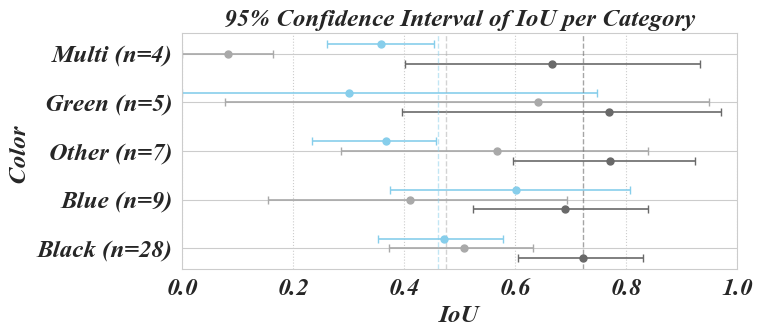

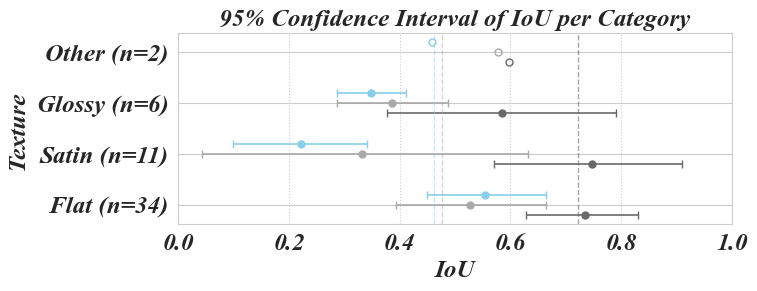

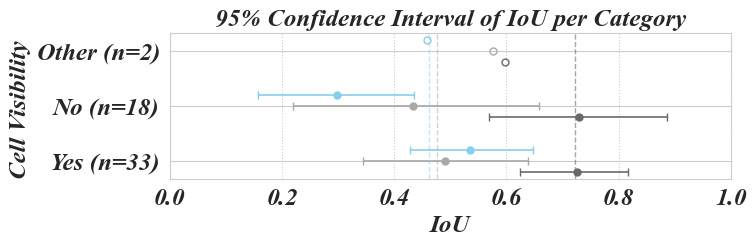

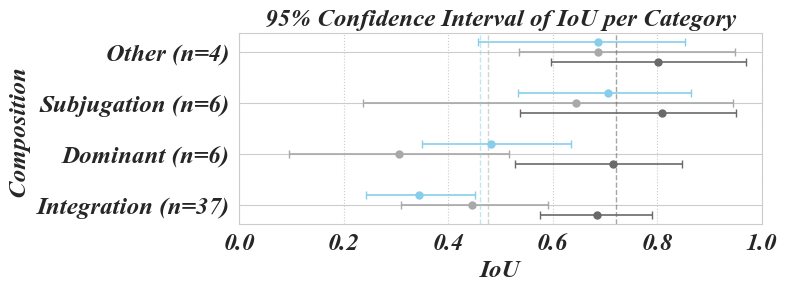

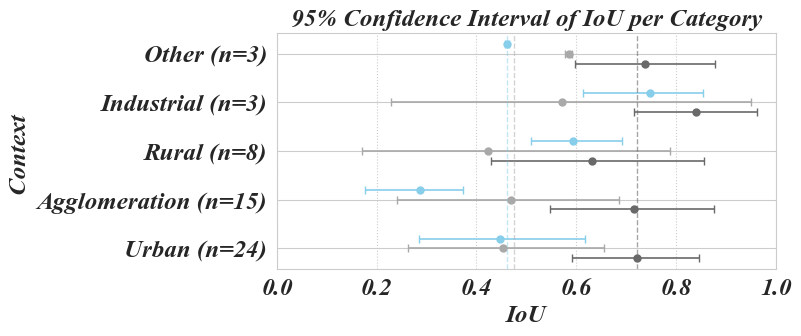

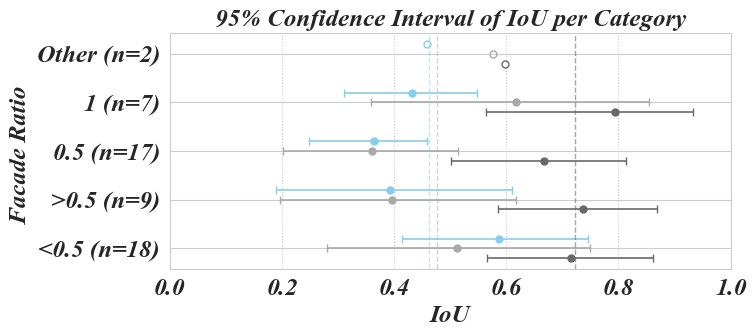

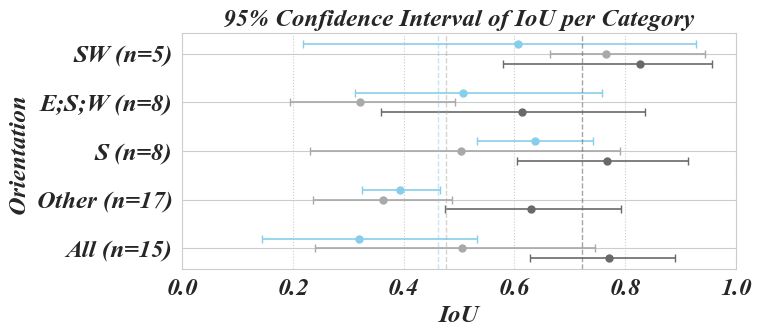

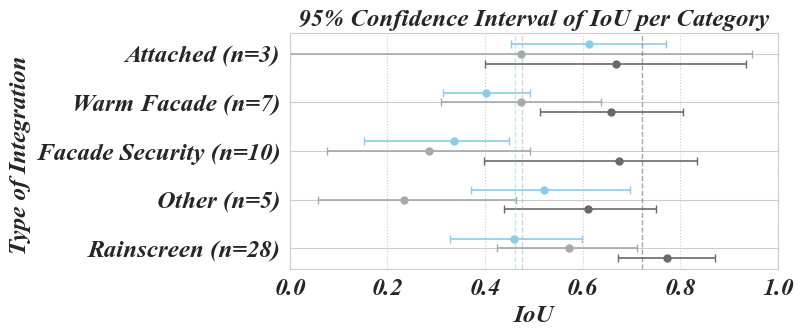

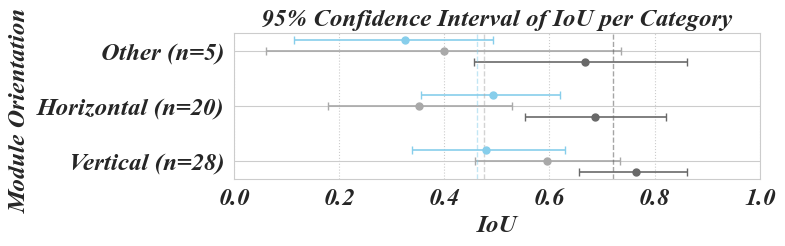

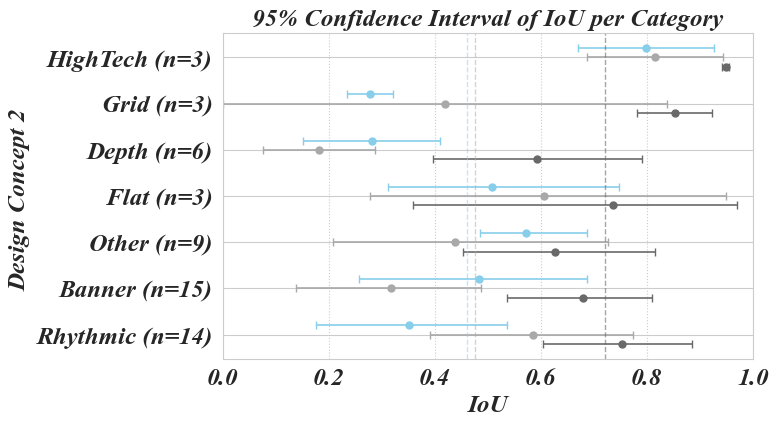

In [14]:
for name, df in collapsed_tables.items():
    name_table = name[:-11]
    fig, ax = forest_from_table(df, name_table)



In [13]:
for i in collapse_summaries.keys():
    collapse_summaries.get(i)  # shows which levels were collapsed
    print(collapsed_tables.get(i + " (collapsed)"))  # the CI table to report

     Color (collapsed)  N images  N projects IoU – SegFormer (95% CI)  \
0                Black        28          13     0.723 [0.605, 0.830]   
1                 Blue         9           6     0.690 [0.524, 0.839]   
2  Other (n=7; proj=3)         7           3     0.771 [0.597, 0.924]   
3                Green         5           3     0.769 [0.397, 0.971]   
4                Multi         4           2     0.667 [0.401, 0.933]   

  IoU – Mask R-CNN (95% CI)  IoU – Human (95% CI)  \
0      0.508 [0.373, 0.633]  0.472 [0.353, 0.578]   
1      0.410 [0.154, 0.693]  0.601 [0.375, 0.808]   
2      0.568 [0.287, 0.839]  0.368 [0.234, 0.458]   
3      0.641 [0.077, 0.949]  0.300 [0.000, 0.748]   
4      0.082 [0.000, 0.163]  0.358 [0.262, 0.454]   

  Δ SegFormer − Human (IoU, 95% CI) Δ SegFormer − Mask R-CNN (IoU, 95% CI)  \
0              0.250 [0.149, 0.357]                   0.215 [0.123, 0.309]   
1             0.089 [-0.091, 0.287]                   0.279 [0.059, 0.514]   
2       